In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pickle
from collections import Counter
import nltk
from pycocotools.coco import COCO
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models


# ----------- Encoder ------------
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # disable learning for parameters
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


# --------- Decoder ----------
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Args:
            embed_size: final embedding size of the CNN encoder
            hidden_size: hidden size of the LSTM
            vocab_size: size of the vocabulary
            num_layers: number of layers of the LSTM
        """
        super(DecoderRNN, self).__init__()

        # Assigning hidden dimension
        self.hidden_dim = hidden_size
        # Map each word index to a dense word embedding tensor of embed_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        # Creating LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # Initializing linear to apply at last of RNN layer for further prediction
        self.linear = nn.Linear(hidden_size, vocab_size)
        # Initializing values for hidden and cell state
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, features, captions):
        """
        Args:
            features: features tensor. shape is (bs, embed_size)
            captions: captions tensor. shape is (bs, cap_length)
        Returns:
            outputs: scores of the linear layer

        """
        # remove <end> token from captions and embed captions
        cap_embedding = self.embed(
            captions[:, :-1]
        )  # (bs, cap_length) -> (bs, cap_length-1, embed_size)

        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)

        #  getting output i.e. score and hidden layer.
        # first value: all the hidden states throughout the sequence. second value: the most recent hidden state
        lstm_out, self.hidden = self.lstm(
            embeddings
        )  # (bs, cap_length, hidden_size), (1, bs, hidden_size)
        outputs = self.linear(lstm_out)  # (bs, cap_length, vocab_size)

        return outputs

    def sample(self, inputs, states=None, max_len=20):
        """
        Generate a caption for the given image features.

        Args:
            inputs (torch.Tensor): Image features of shape (1, 1, embed_size).
            states (tuple): Initial hidden states (h, c) for the LSTM.
            max_len (int): Maximum length of the caption.

        Returns:
            list: List of word indices representing the generated caption.
        """
        res = []

        # Initialize hidden states if not provided
        if states is None:
            h = torch.zeros(1, 1, self.hidden_dim).to(inputs.device)  # (num_layers, batch_size, hidden_size)
            c = torch.zeros(1, 1, self.hidden_dim).to(inputs.device)  # (num_layers, batch_size, hidden_size)
            states = (h, c)

        # Generate caption
        for i in range(max_len):
            lstm_out, states = self.lstm(inputs, states)  # lstm_out: (1, 1, hidden_size)
            outputs = self.linear(lstm_out.squeeze(dim=1))  # outputs: (1, vocab_size)
            _, predicted_idx = outputs.max(dim=1)  # predicted: (1, 1)
            res.append(predicted_idx.item())

            # Stop if the <end> token is generated
            if predicted_idx == 1:  # Assuming 1 is the index of the <end> token
                break

            # Prepare input for the next iteration
            inputs = self.embed(predicted_idx)  # inputs: (1, embed_size)
            inputs = inputs.unsqueeze(1)  # inputs: (1, 1, embed_size)

        return res
class Vocabulary:
    def __init__(
        self,
        vocab_threshold,
        vocab_file="vocab.pkl",
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file=None,
        vocab_from_file=False,
    ):
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, "rb") as f:
                vocab = pickle.load(f)
            self.word2idx = vocab.word2idx
            self.idx2word = vocab.idx2word
            print("Vocabulary successfully loaded from vocab.pkl file!")
        else:
            self.build_vocab()
            with open(self.vocab_file, "wb") as f:
                pickle.dump(self, f)

    def build_vocab(self):
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, idx in enumerate(ids):
            caption = str(coco.anns[idx]["caption"])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
            if i % 100000 == 0:
                print(f"[{i}/{len(ids)}] Tokenizing captions...")
        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]
        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [19]:
# Corrected function
def generateLegends():
    # Load the encoder and decoder
    encoder = torch.load(encoder_path, map_location=device)
    decoder = torch.load(decoder_path, map_location=device)

    # Move models to the correct device
    encoder.to(device)
    decoder.to(device)

    # Set models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Define test images and reference captions
    test_images = ["images/working-together.jpg", "images/match_football.jpg"]
    reference_captions = [
        "A group of students is studying together at a table.",
        "Children are playing soccer in a stadium.",
    ]

    # Load the vocabulary
    with open("vocab.pkl", "rb") as f:
        vocab = pickle.load(f)

    # Process each test image
    for i, image_path in enumerate(test_images):
        try:
            # Generate caption for the image
            caption = generate_caption(image_path, encoder, decoder, vocab)

            # Open and display the image
            image = Image.open(image_path)
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"Reference: {reference_captions[i]}\nGenerated: {caption}")
            plt.show()
        except FileNotFoundError:
            print(f"Image file not found: {image_path}")
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")


Prediction for 'images/working-together.jpg': Photo
It is a photo


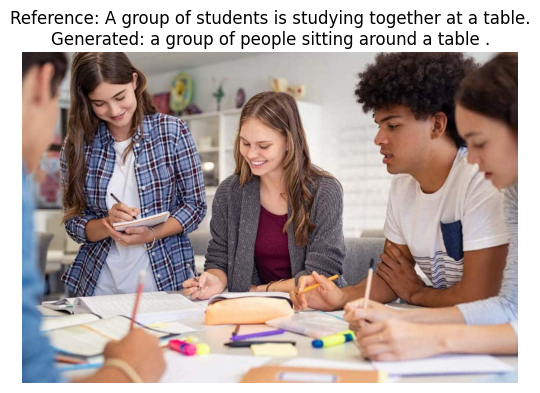

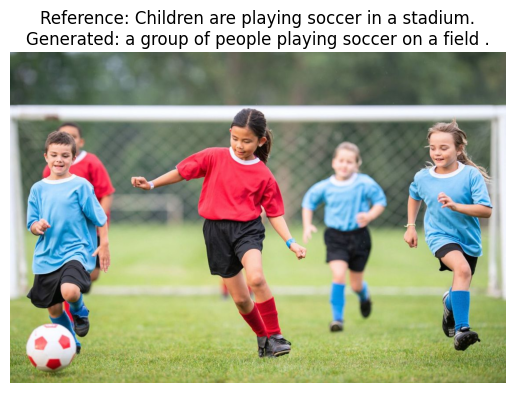

In [20]:
import torch
from torchvision import transforms
from PIL import Image
# Load the saved model
model = torch.load('resnet_photocl_full.pth', map_location=torch.device('cpu'))
model.eval()  # Set the model to evaluation mode

# Define the image preprocessing pipeline (same as used during training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define the class names (make sure this matches the order used during training)
class_names = ['Others', 'Photo']

def predict_image(image_path, model):
    """
    Predict whether the image is "Photo" or "Others".
    """
    # Open the image
    image = Image.open(image_path).convert("RGB")
    
    # Preprocess the image
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)  # Get raw logits
        prob = torch.sigmoid(output).squeeze(1)  # Apply sigmoid to get probabilities
        predicted_class = torch.round(prob).item()  # Convert to binary prediction (0 or 1)
    
    return class_names[int(predicted_class)]

# Test the model with a sample image
test_image_path = "images/working-together.jpg"  # Replace with the path to your image
prediction = predict_image(test_image_path, model)
print(f"Prediction for '{test_image_path}': {prediction}")
if(prediction == 'Photo'):
    print("It is a photo")

    generateLegends()
else:
    print("It is not a photo")

In [21]:
reference_captions = [
    "A group of students is studying together at a table.",
    "Children are playing soccer in a stadium.",
]
generated_captions = [
    "a group of people sitting around a table .",
    "a group of people playing soccer on a field ."
]

In [22]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
# Compute BLEU score
bleu_score = corpus_bleu(
    reference_captions,  # List of reference captions (list of lists)
    generated_captions,  # List of generated captions (list of strings)
    smoothing_function=SmoothingFunction().method1  # Smoothing for short sentences
)

print(f"BLEU Score: {bleu_score:.4f}")

BLEU Score: 0.0051


In [24]:
from rouge import Rouge
# Compute ROUGE scores
rouge = Rouge()
rouge_scores = rouge.get_scores(generated_captions, reference_captions, avg=True)
print("ROUGE Scores:")
print(f"ROUGE-1: {rouge_scores['rouge-1']['f']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge-2']['f']:.4f}")
print(f"ROUGE-L: {rouge_scores['rouge-l']['f']:.4f}")



ROUGE Scores:
ROUGE-1: 0.4353
ROUGE-2: 0.1964
ROUGE-L: 0.4353


In [ ]:
from pycocoevalcap.cider.cider import Cider
# Compute CIDEr score
cider = Cider()
references = {i: [refs] for i, refs in enumerate(reference_captions)}
hypotheses = {i: [gen] for i, gen in enumerate(generated_captions)}
cider_score, _ = cider.compute_score(references, hypotheses)
print(f"CIDEr Score: {cider_score:.4f}")

CIDEr Score: 0.9245
